In [1]:
import pandas as pd
from pymongo import MongoClient

C:\Users\Tay Han\AppData\Local\Temp\ipykernel_57236\577788817.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
pip install pymongo


Note: you may need to restart the kernel to use updated packages.


In [3]:
# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017')
db = client['UserQueries']
collection = db['UserQueries']

# Define your query (empty to fetch all documents)
query = {}

# Specify the fields you want to include (1) or exclude (0)
projection = {
    'id' : 1,
    'created_at' : 1,
    'description' : 1,
    'location' : 1,
    'name' : 1,
    'profile_image_url' : 1, 
    'public_metrics': 1,
    'url' : 1,
    'username' : 1,
    'verified' : 1,
    'entities' : 1
}

# Execute the query
documents = collection.find(query, projection)

# Convert the query result to a pandas DataFrame
df = pd.DataFrame(list(documents))

# Save the DataFrame to CSV
# df.to_csv('output.csv', index=False)

In [4]:
from pandas import json_normalize
df = pd.concat([df, json_normalize(df["entities"])], axis = 1)
df = pd.concat([df, json_normalize(df["public_metrics"])], axis = 1)


In [5]:
#urls
df["url.urls"] = df["url.urls"].fillna(0) 
df["url.urls"] = df["url.urls"].apply(lambda x : len(x) if x else 0)

#number of urls in their descriptions
df["description.urls"] = df["description.urls"].fillna(0) 
df["description.urls"] = df["description.urls"].apply(lambda x : len(x) if x else 0)

#number of mentions
df["description.mentions"] = df["description.mentions"].fillna(0) 
df["description.mentions"] = df["description.mentions"].apply(lambda x : len(x) if x else 0)

#number of hashtags
df["description.hashtags"] = df["description.hashtags"].fillna(0) 
df["description.hashtags"] = df["description.hashtags"].apply(lambda x : len(x) if x else 0)

#number of cashtags
df["description.cashtags"] = df["description.cashtags"].fillna(0) 
df["description.cashtags"] = df["description.cashtags"].apply(lambda x : len(x) if x else 0)

df = df.drop(['entities', 'public_metrics'], axis = 1)

#align the user information with source_user_id to serve as the key for join

df["source_user_id"] = df["id"].apply(lambda x : int(x.replace("u", "")))


In [6]:
import pandas as pd

def convert_mixed_timestamps(ts):
    try:
        # Attempt to convert using the ISO format
        return pd.to_datetime(ts, exact=False, errors='raise')
    except ValueError:
        # Check if ts is not convertable to float (e.g., empty string, '[]')
        try:
            # This will fail if ts is not a valid string representation of a float
            float_ts = float(ts)
        except ValueError:
            # If conversion fails, return None or handle as needed
            return None
        else:
            # If conversion is successful, proceed to convert to datetime
            return pd.to_datetime(float_ts / 1e9, unit='s', utc=True)

In [7]:
#read_csv of tweets
data_types = {'source_user_id': str}
graph = pd.read_csv('tweet_0_sampled_df.csv', dtype = data_types)


FileNotFoundError: [Errno 2] No such file or directory: 'tweet_0_sampled_df.csv'

In [ ]:
# graph["source_user_id"] = graph["source_user_id"].apply(lambda x: int(x))
#Identification of problematic rows that are present

problematic_rows = []
for index, row in graph.iterrows():
    try:
        _ = int(row['source_user_id']) 
        _ = int(row['target_user_id'])
    except ValueError:
        problematic_rows.append(index) 

# Display problematic rows
print("Problematic rows at indices:", problematic_rows)
graph = graph.drop(problematic_rows).reset_index(drop = True)

graph["source_user_id"] = graph["source_user_id"].apply(lambda x: int(x))
graph["target_user_id"] = graph["target_user_id"].apply(lambda x: int(x))

Problematic rows at indices: [1, 2, 3, 4, 7, 8, 9, 10, 11, 12, 18, 19, 21, 22, 23, 36, 40, 45, 47, 48, 58, 62, 63, 64, 69, 70, 72, 73, 74, 76, 77, 81, 84, 90, 91, 97, 98, 108, 109, 111, 113, 115, 120, 137, 138, 150, 152, 164, 165, 169, 170, 175, 182, 188, 189, 192, 203, 206, 209, 210, 219, 220, 230, 239, 248, 249, 279, 282, 284, 288, 289, 290, 292, 300, 303, 305, 307, 314, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 329, 333, 336, 346, 347, 350, 354, 357, 360, 361, 362, 363, 365, 367, 368, 369, 371, 375, 381, 382, 384, 385, 386, 388, 389, 392, 394, 395, 396, 397, 407, 410, 412, 422, 428, 436, 441, 442, 443, 444, 445, 446, 447, 448, 450, 452, 453, 454, 455, 456, 457, 458, 459, 460, 465, 466, 467, 468, 469, 470, 471, 475, 476, 477, 478, 481, 482, 485, 486, 487, 488, 489, 490, 491, 492, 494, 496, 497, 498, 504, 505, 506, 507, 508, 511, 513, 514, 516, 517, 518, 519, 520, 570, 574, 587, 607, 639, 642, 643, 648, 657, 666, 680, 681, 682, 683, 684, 686, 687, 688, 689, 691, 692, 693, 694,

In [ ]:
#convert to timestamp
graph['created_at_timestamp'] = graph['created_at'].apply(convert_mixed_timestamps)

#convert created_at to timestamp
df['created_at_timestamp'] = df['created_at'].apply(convert_mixed_timestamps)

In [ ]:
#Filling NAN values
graph['retweet_count'] = graph['retweet_count'].fillna(0)
graph['reply_count'] = graph['reply_count'].fillna(0)
graph['like_count'] = graph['like_count'].fillna(0)
graph['quote_count'] = graph['quote_count'].fillna(0)

In [ ]:
#user_mention
graph["user_mentions"] = graph["user_mentions"].fillna(0) 
graph["user_mentions"] = graph["user_mentions"].apply(lambda x : len(x) if x else 0)

#user_mention
graph["hastags"] = graph["hastags"].fillna(0) 
graph["hastags"] = graph["hastags"].apply(lambda x : len(x) if x else 0)

#user_mention
graph["symbols"] = graph["symbols"].fillna(0) 
graph["symbols"] = graph["symbols"].apply(lambda x : len(x) if x else 0)

#user_mention
graph["urls"] = graph["urls"].fillna(0) 
graph["urls"] = graph["urls"].apply(lambda x : len(x) if x else 0)

In [ ]:
#Change Assingment for each of computation
g = graph
user = df

In [ ]:
#Feature Engineering 1: Reputation
df['Reputation'] = df['following_count'] / (df['followers_count'] + 1e-9)

In [ ]:
from transformers import BertTokenizer, BertModel
import torch

#Feature Engineering 2: Word Embeddings of user_description, username
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

model = BertModel.from_pretrained('bert-base-uncased', output_hidden_states = True)

def embed_text(text):
    encoded_input = tokenizer(text, return_tensors='pt')

    # Forward pass, get hidden states
    with torch.no_grad():
        outputs = model(**encoded_input)
        # Select the embeddings from the last BERT layer    
        last_layer_embeddings = outputs.last_hidden_state

    word_embedding = last_layer_embeddings[0, 1, :]
    return word_embedding


In [ ]:
#Feature Engineering 3: Retweet Ratio
def retweet_ratio(series):
    if 'Retweet' in series.value_counts():
        return (series.value_counts()['Retweet'] + 1) / (len(series) + 3)
    else:
        return 1/(len(series) + 3)

retweet_ratios = pd.DataFrame(g.groupby('source_user_id')['relationship'].agg(retweet_ratio))
retweet_ratios['source_user_id'] = retweet_ratios.index

retweet_ratios.reset_index(drop=True, inplace=True)

retweet_ratios.columns = ['retweet_ratio', 'source_user_id']

len(retweet_ratios)
# user = pd.merge(user, retweet_ratios, on='source_user_id', how='inner')


17003

In [ ]:
user = pd.merge(user, retweet_ratios, on='source_user_id', how='inner')

,_id,created_at,description,id,location,name,profile_image_url,url,username,verified,...,description.hashtags,description.cashtags,followers_count,following_count,tweet_count,listed_count,source_user_id,created_at_timestamp,Reputation,retweet_ratio
0,65fb0dec836de7adfed6d085,2008-06-23 20:59:59+00:00,"Director, Knowledge Ecology International, an ...",u15211869,"ÜT: 38.911326,-77.04508",James Love,https://pbs.twimg.com/profile_images/126138453...,https://t.co/mcNZxOR7gv,jamie_love,True,...,0,0,10299,2166,57397,383,15211869,2008-06-23 20:59:59+00:00,0.210312,0.142857
1,65fb0dec836de7adfed6d0d2,2020-10-25 23:11:57+00:00,Health Defender,u1320503149816328192,None,Pam Long,https://pbs.twimg.com/profile_images/146760148...,https://t.co/hGfApP0Cj3,PamLongCO,False,...,0,0,33435,399,3553,120,1320503149816328192,2020-10-25 23:11:57+00:00,0.011934,0.193548
2,65fb0dec836de7adfed6d144,2018-07-07 19:38:46+00:00,"Computational arts & humanities, metascience, ...",u1015681547415031808,"Amsterdam, The Netherlands",Giovanni Colavizza,https://pbs.twimg.com/profile_images/101568219...,https://t.co/jxVbOpoVGE,giovanni1085,False,...,0,0,1227,1386,1753,31,1015681547415031808,2018-07-07 19:38:46+00:00,1.129584,0.952381
3,65fb0dec836de7adfed6d149,2009-07-16 17:59:24+00:00,"Economista,UNAM; Máster en Economía de la Escu...",u57398614,Mexico City,Guillermo Barba,https://pbs.twimg.com/profile_images/142837006...,https://t.co/iH646tFH0o,memobarba,True,...,4,0,188745,185225,156094,1015,57398614,2009-07-16 17:59:24+00:00,0.981350,0.937500
4,65fb0dec836de7adfed6d16e,2013-07-10 21:55:53+00:00,Scientist,u1584137959,"Burnaby, BC",Randy McIntosh,https://pbs.twimg.com/profile_images/896440061...,https://t.co/EB5YRSY7Wv,ar0mcintosh,False,...,0,0,3296,1735,43119,106,1584137959,2013-07-10 21:55:53+00:00,0.526396,0.583333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14304,65fb0e70836de7adfee60f2e,2018-12-21 10:33:43+00:00,Freaky doc,u1076063155833499648,"Kisumu, Kenya",Wasike Morgan,https://pbs.twimg.com/profile_images/136323867...,,WasikeMorgan1,False,...,0,0,128,481,257,0,1076063155833499648,2018-12-21 10:33:43+00:00,3.757812,0.214286
14305,65fb0e70836de7adfee60fbe,2010-08-07 00:21:22+00:00,WRITER. ☺️ WEALTHY BITCH ENERGY ALL CENTURY ! ...,u175573935,✨The Writer's Palace ✨,🌬🍃CHUKA CHUKA ⚡️⛈,https://pbs.twimg.com/profile_images/150256826...,https://t.co/5FGWHloACh,chae_chilla,False,...,0,0,4076,3230,383374,52,175573935,2010-08-07 00:21:22+00:00,0.792444,0.793103
14306,65fb0e70836de7adfee6101a,2009-12-12 02:50:07+00:00,Breakfast Sandwich Connoisseur. Cold Brew Enth...,u96260571,"Playa Vista, Los Angeles",Adam Dolin,https://pbs.twimg.com/profile_images/145777794...,,AdamDolin,False,...,0,0,1156,702,1805,9,96260571,2009-12-12 02:50:07+00:00,0.607266,0.357143
14307,65fb0e70836de7adfee61083,2018-09-13 10:44:14+00:00,,u1040189404877340672,"South Dublin, Ireland",David Hennigan,https://abs.twimg.com/sticky/default_profile_i...,,DavidHennigan19,False,...,0,0,13,233,1,0,1040189404877340672,2018-09-13 10:44:14+00:00,17.923077,0.500000


In [ ]:
#Feature Engineering 4: URL Ratio
#URL Ratio = number of URLs posted per user / total number of tweets of user u

#Aggregate URLs
url_count = pd.DataFrame(g.groupby('source_user_id')['urls'].sum())
url_count['source_user_id'] = url_count.index
url_count.reset_index(drop=True, inplace=True)
url_count.columns = ['url_count_tweets', 'source_user_id']
user = pd.merge(user, url_count, on='source_user_id', how='left')

#calculating the url_ratio
user['url_ratio'] = (user["url.urls"] + user["url_count_tweets"]) / user["tweet_count"]

In [ ]:
#Feature Engineering 5: Max Number of URLs per post

#Aggregate URLS
#Aggregate URLs
url_max = pd.DataFrame(g.groupby('source_user_id')['urls'].max())
url_max['source_user_id'] = url_max.index
url_max.reset_index(drop=True, inplace=True)
url_max.columns = ['url_max_tweets', 'source_user_id']
user = pd.merge(user, url_max, on='source_user_id', how='left')


In [ ]:
#Feature Engineering 6: Tweet Time Standard Deviation
import numpy as np

def tweet_time_sd(series):
    if len(series) < 2:
        return np.nan
    time_diffs = series.diff().dt.total_seconds()[1:]

    mean_time_diff = time_diffs.mean()

    sd = (time_diffs - mean_time_diff) ** 2

    mean = np.sqrt(sd.mean()) / 86400

    return mean 

tweet_time_SD = pd.DataFrame(g.groupby('source_user_id')['created_at_timestamp'].agg(tweet_time_sd))
tweet_time_SD['source_user_id'] = tweet_time_SD.index
tweet_time_SD.reset_index(drop=True, inplace=True)
tweet_time_SD.columns = ['time_interval_sd_day', 'source_user_id']

user = pd.merge(user, tweet_time_SD, on='source_user_id', how='left')

In [ ]:
#Feature Engineering 7: Mention Ratio
#Mention Ratio = number of Mentions / total number of tweets of user u

#Aggregate Mentions
mention_count = pd.DataFrame(g.groupby('source_user_id')['user_mentions'].sum())
mention_count['source_user_id'] = mention_count.index
mention_count.reset_index(drop=True, inplace=True)
mention_count.columns = ['mention_count_tweets', 'source_user_id']

#Addition into user
user = pd.merge(user, mention_count, on='source_user_id', how='left')


In [ ]:
#Feature Engineering 8: Max Number of Mention per post

#Aggregate Mentions
mention_max = pd.DataFrame(g.groupby('source_user_id')['user_mentions'].max())
mention_max['source_user_id'] = mention_max.index
mention_max.reset_index(drop=True, inplace=True)
mention_max.columns = ['mention_max_tweets', 'source_user_id']
user = pd.merge(user, mention_max, on='source_user_id', how='left')

In [ ]:
#Feature Engineering 9: Hashtags Ratio
#Hashtags Ratio = number of Mentions / total number of tweets of user u

#Aggregate Mentions
hashtag_count = pd.DataFrame(g.groupby('source_user_id')['hastags'].sum())
hashtag_count['source_user_id'] = hashtag_count.index
hashtag_count.reset_index(drop=True, inplace=True)
hashtag_count.columns = ['hashtag_count_tweets', 'source_user_id']

#Addition into user
user = pd.merge(user, hashtag_count, on='source_user_id', how='left')


In [ ]:
#Feature Engineering 10: Max Number of Hashtags per post

#Aggregate Hashtags
hashtags_max = pd.DataFrame(g.groupby('source_user_id')['hastags'].max())
hashtags_max['source_user_id'] = hashtags_max.index
hashtags_max.reset_index(drop=True, inplace=True)
hashtags_max.columns = ['hashtags_max_tweets', 'source_user_id']
user = pd.merge(user, hashtags_max, on='source_user_id', how='left')

In [ ]:
#Feature Engineering 11: Age of the account
#current date - user creation date / total number of tweets
current_date = pd.Timestamp.now().tz_localize('UTC') 
user['age_of_account'] = (current_date - user["created_at_timestamp"]).dt.days / user["tweet_count"]

In [ ]:
#Retweet Ratio (Done)
#Tweet Time Standard Deviation (Done)
#URL Ratio >> must agregate from user (Done)
#Max number of URLs in tweets (Done)

#Mention Ratio (Done)
#Max number of mentions in tweets (Done)
#Hashtag Ratio (Done)
#Max Number of Hashtags in tweet (Done)

#Age of the account >> current date - user creation date / total number of tweets 
#Average Length of Tweets by user
#Average number of tweets containing URLs
#f64 -- unique ngrams per tweet

# Implementing the labels of the model


In [ ]:
# load the label dataset
labels = pd.read_csv("label.csv")
labels["id"] = labels["id"].str.replace("u","")
labels["id"] = labels["id"].astype("int64")

# convert label to human: 0, bot: 1
labels["label"] = labels["label"].str.replace("human","0")
labels["label"] = labels["label"].str.replace("bot","1")
labels["label"] = labels["label"].astype("int")

labels.head()

,id,label
0,1217628182611927040,0
1,2664730894,0
2,1266703520205549568,0
3,1089159225148882949,0
4,36741729,1


In [ ]:
g = graph

In [ ]:
g = g.merge(labels, how="inner", left_on="source_user_id", right_on="id")
g = g.rename({"label":"source_user_label"}, axis=1)
g = g.drop("id", axis=1)

g = g.merge(labels, how="inner", left_on="target_user_id", right_on="id")
g = g.rename({"label":"target_user_label"}, axis=1)
g = g.drop("id", axis=1)

In [ ]:
#bot and human proportion
display(g['target_user_label'].value_counts())
print()
display(g['source_user_label'].value_counts())

target_user_label
0    187176
1      4337
Name: count, dtype: int64

source_user_label
0    179051
1     12462
Name: count, dtype: int64

In [ ]:
#preprocess tweets + aggregation# preprocess the tweets

import re
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Download necessary NLTK data
nltk.download('wordnet')
nltk.download('stopwords')

# Initialize tokenizer and lemmatizer
tokenizer = TweetTokenizer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

# Data cleaning, tokenization and lemmatization
def preprocess_tweets(tweet):
    tweet_cleaned = re.sub(r'https?://[^ ]+', '', tweet)  # Remove URLs
    tweet_cleaned = re.sub(r'@\w+', '', tweet_cleaned)    # Remove mentions
    tweet_cleaned = re.sub(r'RT', '', tweet_cleaned)      # Remove RT
    tweet_cleaned = tweet_cleaned.lower()                 # Convert to lowercase
    tweet_cleaned = re.sub(r'[^\w\s]', '', tweet_cleaned) # Remove punctuation

    # Tokenization
    tokens = tokenizer.tokenize(tweet_cleaned)

    # Stop words removal and lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]

    return tokens

g["tokens"] = g["text"].apply(preprocess_tweets)


[nltk_data] Downloading package wordnet to C:\Users\Tay
[nltk_data]     Han\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\Tay
[nltk_data]     Han\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,source_user_id,conversation_id,created_at,tweet_id,text,user_mentions,hastags,symbols,urls,retweet_count,reply_count,like_count,quote_count,relationship,target_user_id,created_at_timestamp,source_user_label,target_user_label,tokens
0,62524415,23142526007,2010-09-06 12:59:25+00:00,t23142526007,@geneliad i like ur D.P u luk awesum in dis pi...,114,2,2,2,0,0.0,1.0,0.0,Reply,92726549,2010-09-06 12:59:25+00:00,0,0,"[like, ur, dp, u, luk, awesum, dis, pic]"
1,62524415,20708534473,2010-08-09 13:40:08+00:00,t20708534473,RT @bani_j: URGENTLY needed type AB+ blood for...,222,2,2,2,55,0.0,0.0,0.0,Retweet,29951362,2010-08-09 13:40:08+00:00,0,0,"[urgently, needed, type, ab, blood, grandmothe..."
2,62524415,19906485033,2010-07-30 12:37:48+00:00,t19906485033,@gulpanag #hellodarling hello hello hello,107,47,2,2,0,0.0,0.0,0.0,Reply,23061619,2010-07-30 12:37:48+00:00,0,0,"[hellodarling, hello, hello, hello]"
3,62524415,19659760401,2010-07-27 14:14:52+00:00,t19659760401,@gulpanag if u want 2 discribe HeLLODARLING in...,107,2,2,2,0,0.0,0.0,0.0,Reply,23061619,2010-07-27 14:14:52+00:00,0,0,"[u, want, 2, discribe, hellodarling, one, word..."
4,62524415,19659599171,2010-07-27 14:12:38+00:00,t19659599171,@sonamakapoor ystrdy saw ihateluvstory ...it w...,116,2,2,2,0,0.0,0.0,0.0,Reply,51376979,2010-07-27 14:12:38+00:00,0,0,"[ystrdy, saw, ihateluvstory, gud, movie]"


In [ ]:
#make sure that all the source and target users have user information

g = g[g['source_user_id'].isin(user['source_user_id'])]
g = g[g['target_user_id'].isin(user['source_user_id'])]

In [ ]:
import gensim
import gensim.downloader as api

# Load the GloVe model (choose the desired model size, e.g., 'glove-twitter-100' for Twitter data)
glove_model = api.load('glove-twitter-100')

def get_tweet_embedding(tweet_tokens, glove_model):

    # Retrieve GloVe embeddings for each token
    embeddings = [glove_model[token] for token in tweet_tokens if token in glove_model]

    # Handle tweets with no tokens found in the GloVe model
    if not embeddings:
        return None

    # Aggregate the embeddings, e.g., by averaging
    tweet_embedding = sum(embeddings) / len(embeddings)
    return tweet_embedding

g["tweet_embedding"] = g["tokens"].apply(lambda x : get_tweet_embedding(x, glove_model))

,source_user_id,conversation_id,created_at,tweet_id,text,user_mentions,hastags,symbols,urls,retweet_count,reply_count,like_count,quote_count,relationship,target_user_id,created_at_timestamp,source_user_label,target_user_label,tokens,tweet_embedding
0,431624965,1498000074739232768,2022-02-27 18:20:23+00:00,t1498000074739232769,Bingo 😏 https://t.co/p2GihtTKVL,2,2,2,184,3,0.0,19.0,0.0,Reply,431624965,2022-02-27 18:20:23+00:00,0,0,[bingo],"[-1.0966, 0.56576, 0.23174, 0.10125, -0.29368,..."
1,431624965,1497930143863611392,2022-02-27 13:42:31+00:00,t1497930143863611395,PS: la coercition nucléaire ça ne veut pas dir...,2,2,2,2,21,0.0,178.0,0.0,Reply,431624965,2022-02-27 13:42:31+00:00,0,0,"[p, la, coercition, nucléaire, ça, ne, veut, p...","[0.44893932, -0.117404185, -0.9105887, 0.21079..."
2,20558786,1491578925021118464,2022-02-10 01:05:02+00:00,t1491578925021118465,@Cooopahtroopa Find a way to use it on TikTok/...,126,2,2,2,0,0.0,0.0,0.0,Reply,305830702,2022-02-10 01:05:02+00:00,0,0,"[find, way, use, tiktokweb, 2, awareness, acce...","[0.0026077405, 0.0001100873, -0.054195534, 0.2..."
3,1547353146,1485486227096993792,2022-01-24 05:34:50+00:00,t1485486227096993795,cc @ArkaMehatari,138,2,2,2,0,0.0,1.0,0.0,Reply,1547353146,2022-01-24 05:34:50+00:00,1,1,[cc],"[0.37464, 0.065646, -0.31762, -0.33478, 0.3080..."
4,1547353146,1481237363087278080,2022-01-12 12:11:22+00:00,t1481237363087278082,Many people (especially in professional sphere...,2,2,2,2,0,0.0,6.0,0.0,Reply,1547353146,2022-01-12 12:11:22+00:00,1,1,"[many, people, especially, professional, spher...","[0.22436845, 0.022193432, 0.121412225, 0.19920..."


In [ ]:
# drop rows with no tweet_embeddings

g = g.dropna()
g = g.reset_index(drop=True)


,source_user_id,conversation_id,created_at,tweet_id,text,user_mentions,hastags,symbols,urls,retweet_count,reply_count,like_count,quote_count,relationship,target_user_id,created_at_timestamp,source_user_label,target_user_label,tokens,tweet_embedding
0,431624965,1498000074739232768,2022-02-27 18:20:23+00:00,t1498000074739232769,Bingo 😏 https://t.co/p2GihtTKVL,2,2,2,184,3,0.0,19.0,0.0,Reply,431624965,2022-02-27 18:20:23+00:00,0,0,[bingo],"[-1.0966, 0.56576, 0.23174, 0.10125, -0.29368,..."
1,431624965,1497930143863611392,2022-02-27 13:42:31+00:00,t1497930143863611395,PS: la coercition nucléaire ça ne veut pas dir...,2,2,2,2,21,0.0,178.0,0.0,Reply,431624965,2022-02-27 13:42:31+00:00,0,0,"[p, la, coercition, nucléaire, ça, ne, veut, p...","[0.44893932, -0.117404185, -0.9105887, 0.21079..."
2,20558786,1491578925021118464,2022-02-10 01:05:02+00:00,t1491578925021118465,@Cooopahtroopa Find a way to use it on TikTok/...,126,2,2,2,0,0.0,0.0,0.0,Reply,305830702,2022-02-10 01:05:02+00:00,0,0,"[find, way, use, tiktokweb, 2, awareness, acce...","[0.0026077405, 0.0001100873, -0.054195534, 0.2..."
3,1547353146,1485486227096993792,2022-01-24 05:34:50+00:00,t1485486227096993795,cc @ArkaMehatari,138,2,2,2,0,0.0,1.0,0.0,Reply,1547353146,2022-01-24 05:34:50+00:00,1,1,[cc],"[0.37464, 0.065646, -0.31762, -0.33478, 0.3080..."
4,1547353146,1481237363087278080,2022-01-12 12:11:22+00:00,t1481237363087278082,Many people (especially in professional sphere...,2,2,2,2,0,0.0,6.0,0.0,Reply,1547353146,2022-01-12 12:11:22+00:00,1,1,"[many, people, especially, professional, spher...","[0.22436845, 0.022193432, 0.121412225, 0.19920..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35310,101075559,1495945455397752832,2022-02-22 02:16:04+00:00,t1495945455397752832,RT @FilthyBrotherz: Of course we’re Legendary....,123,2,2,2,1,0.0,0.0,0.0,Retweet,101075559,2022-02-22 02:16:04+00:00,0,0,"[course, legendary, secret]","[0.042365, 0.038859997, -0.14189167, -0.0995, ..."
35311,1240170150969688064,1458128514432053248,2021-11-09 17:45:03+00:00,t1458128514432053251,RT @blg_journal: Did you know that Biological ...,142,2,2,2,5,0.0,0.0,0.0,Retweet,1321149318288580608,2021-11-09 17:45:03+00:00,0,0,"[know, biological, imaging, accepts, following...","[0.26183793, -0.040786378, -0.1270319, -0.0883..."
35312,1240170150969688064,1456378688002527232,2021-11-04 21:51:52+00:00,t1456378688002527241,RT @ZachMarin__: How cool! I first started wor...,129,2,2,2,2,0.0,0.0,0.0,Retweet,893576817235415040,2021-11-04 21:51:52+00:00,0,0,"[cool, first, started, working, 7, year, ago, ...","[0.072935246, -0.060111836, -0.010010255, -0.2..."
35313,1240170150969688064,1454411991888564224,2021-10-30 11:36:55+00:00,t1454411991888564228,RT @blg_journal: Exciting meeting focusing on ...,142,2,2,2,4,0.0,0.0,0.0,Retweet,1321149318288580608,2021-10-30 11:36:55+00:00,0,0,"[exciting, meeting, focusing, biological, tech...","[0.11355, -0.09157889, 0.1880331, 0.081133336,..."


In [ ]:
users = g[["source_user_id", "source_user_label"]]
users = users.rename({"source_user_id":"user_id", "source_user_label":"label"}, axis=1)
targets = g[["target_user_id", "target_user_label"]]
targets = targets.rename({"target_user_id":"user_id", "target_user_label":"label"}, axis=1)
id_label = pd.concat([users,targets], axis=0, ignore_index=True).drop_duplicates()

id_label


,user_id,label
0,431624965,0
2,20558786,0
3,1547353146,1
5,1513820898,0
6,2394338480,0
...,...,...
70246,19026288,0
70280,1169950790,0
70300,235180346,0
70571,931972119365324800,0


In [ ]:
id_label = pd.merge(id_label, user, how = "inner", left_on = 'user_id', right_on = "source_user_id")

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.preprocessing import LabelEncoder

# Create a mapping of user IDs to node indices >> change it up to index
user_ids = id_label["user_id"]
user_labels = id_label["label"]
user_to_idx = {user_id: idx for idx, user_id in enumerate(id_label["user_id"])}

# Create edge index and edge weight tensors
edge_list = []
edge_weight_dict = {}

for _, row in g.iterrows():
    source_idx = user_to_idx[row['source_user_id']]
    target_idx = user_to_idx[row['target_user_id']]
    idx_pair = (source_idx, target_idx)
    if (idx_pair not in edge_list) :
        edge_list.append(idx_pair)
        edge_weight_dict[idx_pair] = 1
    else:
        edge_weight_dict[idx_pair] += 1

edge_weight_list = list(edge_weight_dict.values())

#force it to be contiguous
edge_index = torch.tensor(edge_list, dtype=torch.long).t().contiguous()
edge_weight = torch.tensor(edge_weight_list, dtype=torch.float)

In [ ]:
# aggregate the tweet embeddings for each user
# create a single function for both the user information and the embeddings
def aggregate(user_id):
    user = g[g['source_user_id'] == user_id]
    if user.size != 0:
        embeddings = np.stack(user['tweet_embedding'].values)
    else:
        # if user did not make any tweets
        embeddings = np.zeros((1,100))
    tensor_tweet = torch.mean(torch.from_numpy(embeddings), dim=0)
    # print(tensor_tweet.shape)
    lol = list(id_label[id_label["source_user_id"] == user_id].values.tolist())
    # print(lol)
    # print(user_id)
    lol1 = lol[0][23:]
    tensor_user = torch.tensor(lol1)
    return torch.cat((tensor_tweet, tensor_user))

node_features = torch.stack([aggregate(user_id) for user_id in user_ids])

In [ ]:
n = pd.DataFrame(node_features)
u_lab = pd.DataFrame(user_labels)

In [ ]:

# build the GCN with 2 convolutional layers
class BaselineGCN(torch.nn.Module):
    def __init__(self, num_features, num_classes):
        super(BaselineGCN, self).__init__()
        self.conv1 = GCNConv(num_features, 64)
        self.conv2 = GCNConv(64, num_classes)

    def forward(self, x, edge_index, edge_weight):
        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_weight))
        x = self.conv2(x, edge_index, edge_weight=edge_weight)
        return F.log_softmax(x, dim=1)

# create a PyTorch Geometric data object
data = Data(x=node_features.float(), y=torch.from_numpy(user_labels.values).long(), edge_index=edge_index, edge_weight=edge_weight)

# instantiate the model
model = BaselineGCN(num_features=node_features.size(1), num_classes=2)

# define loss function and optimizer
criterion = torch.nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
from torch_geometric.transforms import RandomNodeSplit

# 80% train, 10% val and 10% test
transform = RandomNodeSplit(num_val=0.1, num_test=0.1)
data = transform(data)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index, data.edge_weight)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    print(f"Training Loss: {loss.item()}")
    return loss

def validate():
    model.eval()
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.edge_weight)
        loss = criterion(out[data.val_mask], data.y[data.val_mask])
        pred = out.argmax(dim=1)
        correct = (pred[data.val_mask] == data.y[data.val_mask]).sum()
        acc = int(correct) / int(data.val_mask.sum())
        print(f"Validation Loss: {loss.item()}, Validation Accuracy: {acc}")
    return loss, acc

for epoch in range(10):
    loss = train()
    val_loss, val_acc = validate()
    print(f'Epoch {epoch+1} | Train Loss: {loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

Training Loss: nan
Validation Loss: nan, Validation Accuracy: 0.948180815876516
Epoch 1 | Train Loss: nan, Val Loss: nan, Val Acc: 0.9482
Training Loss: nan
Validation Loss: nan, Validation Accuracy: 0.948180815876516
Epoch 2 | Train Loss: nan, Val Loss: nan, Val Acc: 0.9482
Training Loss: nan
Validation Loss: nan, Validation Accuracy: 0.948180815876516
Epoch 3 | Train Loss: nan, Val Loss: nan, Val Acc: 0.9482
Training Loss: nan
Validation Loss: nan, Validation Accuracy: 0.948180815876516
Epoch 4 | Train Loss: nan, Val Loss: nan, Val Acc: 0.9482
Training Loss: nan
Validation Loss: nan, Validation Accuracy: 0.948180815876516
Epoch 5 | Train Loss: nan, Val Loss: nan, Val Acc: 0.9482
Training Loss: nan
Validation Loss: nan, Validation Accuracy: 0.948180815876516
Epoch 6 | Train Loss: nan, Val Loss: nan, Val Acc: 0.9482
Training Loss: nan
Validation Loss: nan, Validation Accuracy: 0.948180815876516
Epoch 7 | Train Loss: nan, Val Loss: nan, Val Acc: 0.9482
Training Loss: nan
Validation Loss

In [ ]:
def test():
    model.eval()
    with torch.no_grad():
        out = model(data.x.float(), data.edge_index, data.edge_weight)
        test_loss = criterion(out[data.test_mask], data.y[data.test_mask].long())
        pred = out.argmax(dim=1)
        correct = (pred[data.test_mask] == data.y[data.test_mask]).sum()
        acc = int(correct) / int(data.test_mask.sum())
    return pred[data.test_mask], data.y[data.test_mask], test_loss, acc

test_pred, test_labels, test_loss, test_acc = test()
print(f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}')

Test Loss: nan, Test Acc: 0.9383


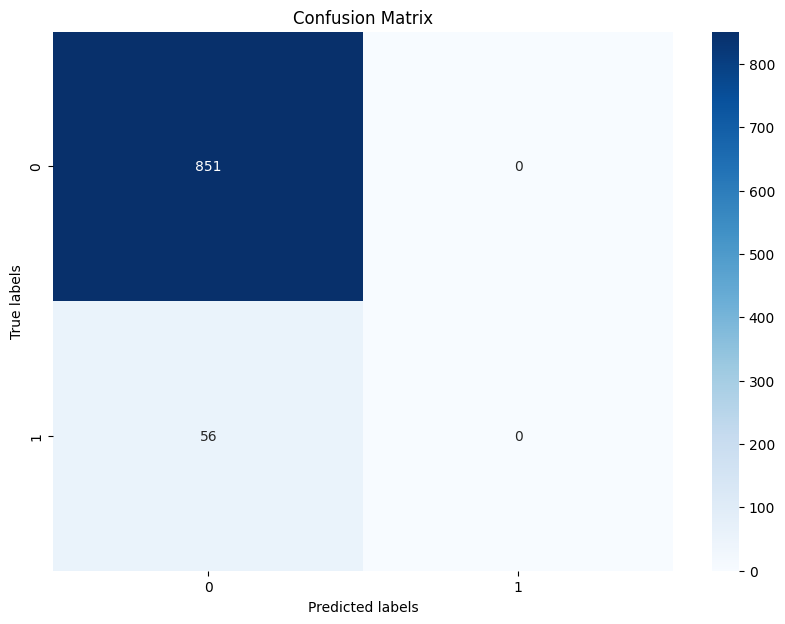

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np

# Calculate the confusion matrix
cm = confusion_matrix(test_labels.cpu().numpy(), test_pred.cpu().numpy())

# Plot the confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()
